##TIME SERIES ANALYSIS
###Goal: Find outliers, trends and periodicity in the MTA turnstile data
###DATA:
MTA subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.
The data was organized by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy.
It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [357]:
# Load the libraries. 
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import pylab as pl

import os
s = json.load( open(os.getenv('PUI2015')+"/ylai_matplotlibrc.json") )
pl.rcParams.update(s)

%pylab inline
#import urllib2 as url
import subprocess

Populating the interactive namespace from numpy and matplotlib


Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014.

The data are available to you as a python data cube here:

you can load it as:__np.load(“MTA_Fare.npy")__ and you will end up with a python numpy array of shape (600,23,194)

__Note that the missing values are inputted as -1.__

If you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans: np.nanmean np.nansum...

In [3]:
#Read data:
df = np.load('MTA_Fare.npy')
type (df)

numpy.ndarray

In [4]:
mta = np.where(df !=-1, df, NaN)
mta.shape

(600, 23, 194)

###Task 1:
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it and figure out what it is due to.

In [5]:
#Sum up all 23 different ridership by stations and time.
mta1 = np.nansum(mta, axis=1, dtype=None, out=None, keepdims=0)
mta1.shape
mta2 = mta1.transpose()
mta2.shape

(194, 600)

In [6]:
#Convert array to a dataframe:
mta_data = pd.DataFrame(mta2)

In [7]:
# Since  per week for 194 weeks from 05/21/2010 to 02/21/2014.
mta_data.index = pd.Index(pd.date_range(
                                pd.to_datetime('05/21/2010'),
                                pd.to_datetime('02/07/2014'),
                                freq='W'
                            ))


In [207]:
mta_data[:5]

0      1     2      3      4      5      6      7      8    \
2010-05-23  126878  37306  6606  16378  18564  19987  12449  11091  10482   
2010-05-30  149477  46464  6881  17408  19903  20625  13644  11659  11030   
2010-06-06  152383  49359  7229  17595  19948  21225  13719  12037  10881   
2010-06-13  160175  44849  5731  14242  16076  17412  11460   9809   9123   
2010-06-20  162641  41509  7032  17589  20283  20909  14094  11944  10923   

               9   ...   590  591  592  593  594  595  596  597  598  599  
2010-05-23  147187 ...     0    0    0    0    0    0    0    0    0    0  
2010-05-30  154826 ...     0    0    0    0    0    0    0    0    0    0  
2010-06-06  155958 ...     0    0    0    0    0    0    0    0    0    0  
2010-06-13  154914 ...     0    0    0    0    0    0    0    0    0    0  
2010-06-20  157628 ...     0    0    0    0    0    0    0    0    0    0  

[5 rows x 600 columns]

In [361]:
plt.figure(figsize=(20,10))
pl.plot(mta_data.index, np.log10(mta_data)/23) 
pl.ylabel("Rider Volume", fontsize=12)
pl.xlabel("Week", fontsize=12)

In [10]:
#Sum all the ridership from 600 stations in one time-series.
mta3 = np.nansum(mta2, axis=1, dtype=None, out=None, keepdims=0)
mta3.shape
#Convert array to a dataframe:
mta_data3 = pd.DataFrame(mta3)

# Since  per week for 194 weeks from 05/21/2010 to 02/21/2014.
mta_data3.index = pd.Index(pd.date_range(
                                pd.to_datetime('05/21/2010'),
                                pd.to_datetime('02/07/2014'),
                                freq='W'
                            ))

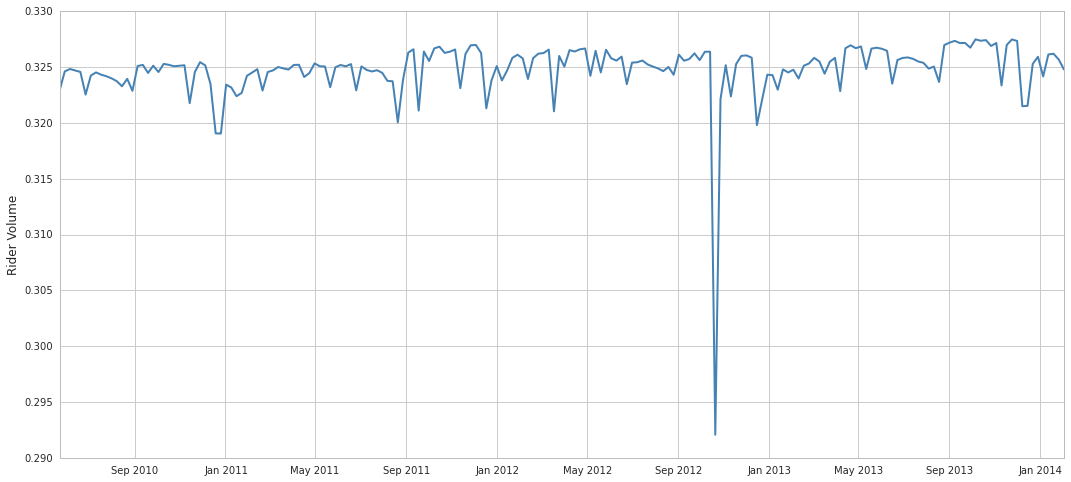

In [358]:
plt.figure(figsize=(18,8))
pl.plot(mta_data3.index, np.log10(mta_data3)/23)
pl.ylabel("Rider Volume", fontsize=12)
#pl.xlabel("Week", fontsize=12)

The mean and stardand deviation of the time series can be used to set a __3-sigma threshold__.

Every value that is more then 3 sigma's away from the mean can be flaged as an event


In [371]:
print (mta_data3[0].mean(), mta_data3[0].std())
thresholds = [mta_data3[0].mean() + 3*mta_data3[0].std(), 
              mta_data3[0].mean() - 3*mta_data3[0].std()]
print (thresholds)

29781349.8711 2991680.90141
[38756392.57537587, 20806307.16689217]


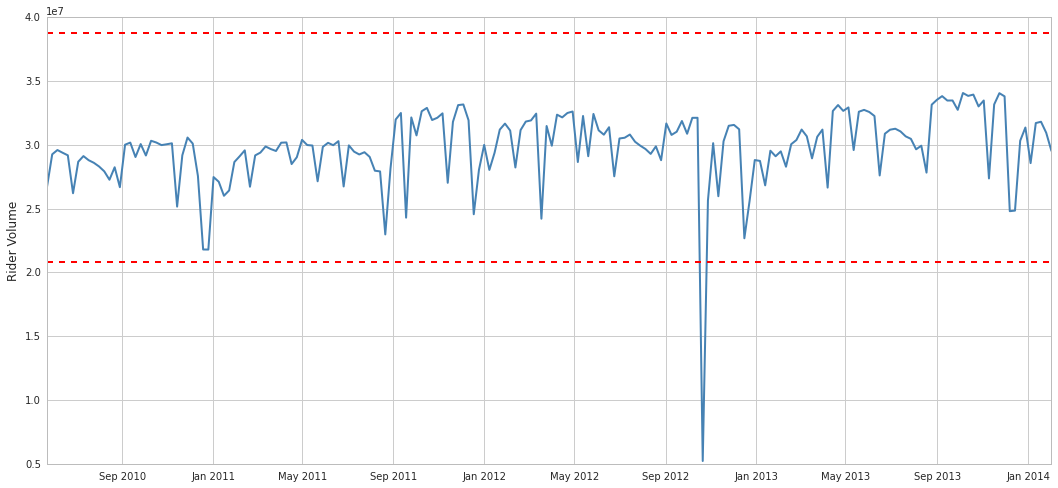

In [379]:
plt.figure(figsize=(18,8))

ax = pl.plot(mta_data3.index, mta_data3)
pl.ylabel("Rider Volume", fontsize=12)
plt.axhline(thresholds[0], color='r', linestyle='--')
plt.axhline(thresholds[1], color='r', linestyle='--')

Notice there is a big drop betwee Sep 2012 and Jan 2013. 

That is __Hunrrican Sanday__ which is from Oct. 21 to Oct.31 2014.

###Task 2:
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


__NOTE ON THE TREND DETECTION:__

You should find the ride type that has the steepest increase, and the steepest decrease. Notice: We are looking for something that has a more or less constant trend. To do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type.

You can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

Notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.

In [14]:
from __future__ import print_function
import numpy as np
from scipy import stats
import os
import json
import pylab as pl
#s = json.load(open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json'));
#pl.rcParams.update(s)

import matplotlib
%matplotlib nbagg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
#Sum up all 23 different ridership by stations and time.
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']
mta4 = np.nanmean(mta, axis=0, dtype=None, out=None, keepdims=0)
mta4 = mta4.transpose()
mta4.shape

(194, 23)

In [16]:
#Convert array to a dataframe:
mta_data4 = pd.DataFrame(mta4)
# Since  per week for 194 weeks from 05/21/2010 to 02/21/2014.
mta_data4.index = pd.Index(pd.date_range(
                                pd.to_datetime('05/21/2010'),
                                pd.to_datetime('02/07/2014'),
                                freq='W'
                            ))

In [17]:
type (mta_data4)

pandas.core.frame.DataFrame

In [18]:
mta_data4.columns = ridetype

In [19]:
mta_data4[:5]

10t          14d          1d          2t         30d  \
2010-05-23  24880.119048  1148.320346  103.465368  403.790043  101.316017   
2010-05-30  27173.229935  1265.798265  111.683297  432.167028  139.594360   
2010-06-06  27573.708423  1266.077754  111.524838  431.248380  123.097192   
2010-06-13  27329.751620  1215.123110  112.447084  424.166307   80.840173   
2010-06-20  27607.099138  1182.883621  110.243534  420.006466   75.883621   

                     7d           ada       afas         exp           ez  \
2010-05-23  8003.123377  18510.686147  21.781385  721.205628  1108.294372   
2010-05-30  8637.327549  20577.861171  25.698482  613.351410  1253.845987   
2010-06-06  8710.647948  20467.684665  26.516199  652.328294  1329.453564   
2010-06-13  8710.049676  20410.542117  24.235421  659.855292  1309.438445   
2010-06-20  8460.012931  20030.176724  22.661638  723.663793  1214.323276   

            ...        month          rfm          rr        sen     spec  \
2010-05-23  ...   266.523810  1710.194805  129.456710  61.084416  0.00000   
2010-05-30  ...   329.605206  1969.778742  150.127983  70.136659  0.00000   
2010-06-06  ...   327.295896  1974.349892  150.267819  70.449244  0.00000   
2010-06-13  ...   317.697624  1949.349892  147.082073  69.987041  0.00000   
2010-06-20  ...   297.172414  1843.907328  143.053879  68.821121  0.37931   

                  tcmc          t      umlim      xbus  stud  
2010-05-23  269.898268  45.584416  13.264069  0.774892   NaN  
2010-05-30  264.019523  47.006508  13.275488  1.028200   NaN  
2010-06-06  263.889849  46.291577  14.017279  1.004320   NaN  
2010-06-13  263.609071  46.717063  14.233261  1.045356   NaN  
2010-06-20  258.137931  43.743534  13.605603  0.974138   NaN  

[5 rows x 23 columns]

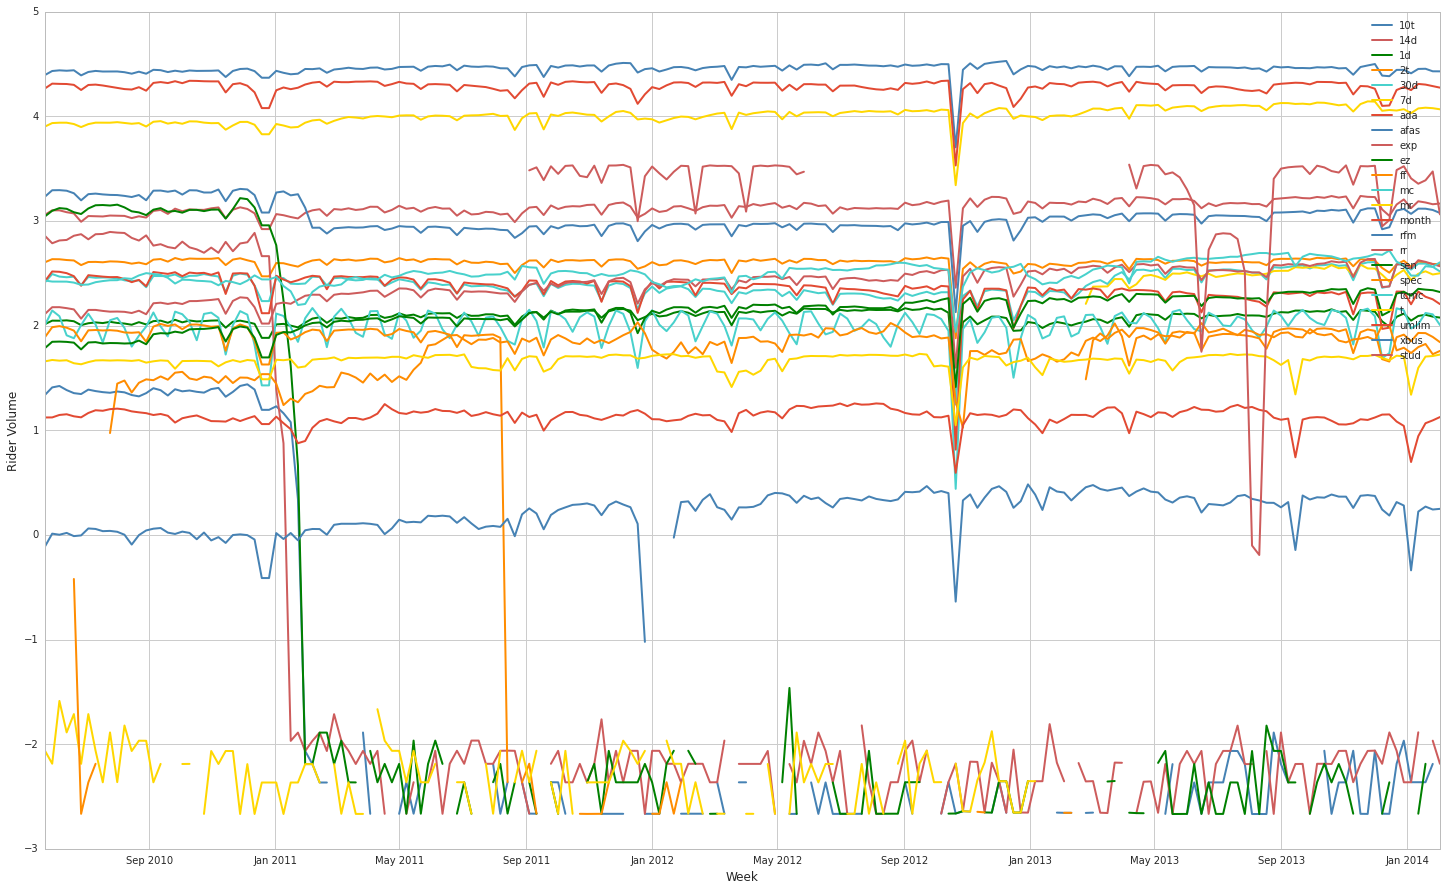

In [380]:
plt.figure(figsize=(25,15))
pl.plot(mta_data4.index, np.log10(mta_data4)) 
pl.ylabel("Rider Volume", fontsize=12)
pl.xlabel("Week", fontsize=12)
pl.legend(mta_data4.columns)

In [85]:
#plt.figure(figsize=(18,8))
#plt.plot (mta_data3.index,mta_data4['10t'])

In [381]:
#pd.rolling_mean(mta_data4, window=2, min_periods=None, freq=None, center=False, how=None)
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
          'umlim','xbus','stud']

fig = plt.figure(figsize=(35,35)) 
x = 1

for i in ridetype:
    plt.title('non-stationary mean',fontsize = 20)
    y = pd.rolling_mean(mta_data4[i], 30)
    ax = fig.add_subplot(8,3,x)
    ax.plot(mta_data4.index,y)
    pl.ylabel("Rider Volume", fontsize=15)
    #pl.xlabel("Week", fontsize=15)
    pl.legend([i], fontsize = 15)
    x = x+1  

In [382]:
fig = plt.figure(figsize=(35,35)) 
x = 1

for i in ridetype:
    plt.title('Variance',fontsize = 20)
    y = pd.rolling_std(mta_data4[i], 30)
    ax = fig.add_subplot(8,3,x)
    ax.plot(mta_data4.index,y)
    pl.ylabel("Rider Volume", fontsize=15)
    #pl.xlabel("Week", fontsize=15)
    pl.legend([i], fontsize = 15)
    x = x+1  

###Visually based on the plots above, we can tell that there are trends in certain rider types:
__Increasing__ population for 7-day pass('7d'), 14-day pass('14d'), Rail Road('rr'), and Senior Citizen ('sen')

On the other hand, there is a __decreasing__ trend of Monthly Rider ('month').

In [170]:
for i in ridetype:
    mta_data4[i].tail().mean()
    z = mta_data4[i].tail().mean()/mta_data4[i].mean()
    print ('Ratio of last 4 weeks riders of %s to average is %s' % ([i],z))

Ratio of last 4 weeks riders of ['10t'] to average is 0.953035495427
Ratio of last 4 weeks riders of ['14d'] to average is 1.07166508611
Ratio of last 4 weeks riders of ['1d'] to average is 0.99074217181
Ratio of last 4 weeks riders of ['2t'] to average is 0.962264704606
Ratio of last 4 weeks riders of ['30d'] to average is 1.06333245438
Ratio of last 4 weeks riders of ['7d'] to average is 1.12565951789
Ratio of last 4 weeks riders of ['ada'] to average is 0.99712314314
Ratio of last 4 weeks riders of ['afas'] to average is 0.000957105831048
Ratio of last 4 weeks riders of ['exp'] to average is 6.58744861348e-05
Ratio of last 4 weeks riders of ['ez'] to average is 1.00951791519e-05
Ratio of last 4 weeks riders of ['ff'] to average is 1.58169530548
Ratio of last 4 weeks riders of ['mc'] to average is 1.40206024451
Ratio of last 4 weeks riders of ['mr'] to average is 3.87971888416
Ratio of last 4 weeks riders of ['month'] to average is 0.770389870417
Ratio of last 4 weeks riders of ['rfm

###Task 3:
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In this case we need to creat 600 stations' time series with __a period of 52 weeks__.

In [171]:
from datetime import datetime
import calendar 

In [173]:
#In this case we loook at the day with 600 stations in 194 weeks:
mta_data[:5]

0      1     2      3      4      5      6      7      8    \
2010-05-23  126878  37306  6606  16378  18564  19987  12449  11091  10482   
2010-05-30  149477  46464  6881  17408  19903  20625  13644  11659  11030   
2010-06-06  152383  49359  7229  17595  19948  21225  13719  12037  10881   
2010-06-13  160175  44849  5731  14242  16076  17412  11460   9809   9123   
2010-06-20  162641  41509  7032  17589  20283  20909  14094  11944  10923   

               9   ...   590  591  592  593  594  595  596  597  598  599  
2010-05-23  147187 ...     0    0    0    0    0    0    0    0    0    0  
2010-05-30  154826 ...     0    0    0    0    0    0    0    0    0    0  
2010-06-06  155958 ...     0    0    0    0    0    0    0    0    0    0  
2010-06-13  154914 ...     0    0    0    0    0    0    0    0    0    0  
2010-06-20  157628 ...     0    0    0    0    0    0    0    0    0    0  

[5 rows x 600 columns]

In [277]:
freq = 1
period = 52*freq
sample_rate = 1
duration = 194
N = duration * sample_rate

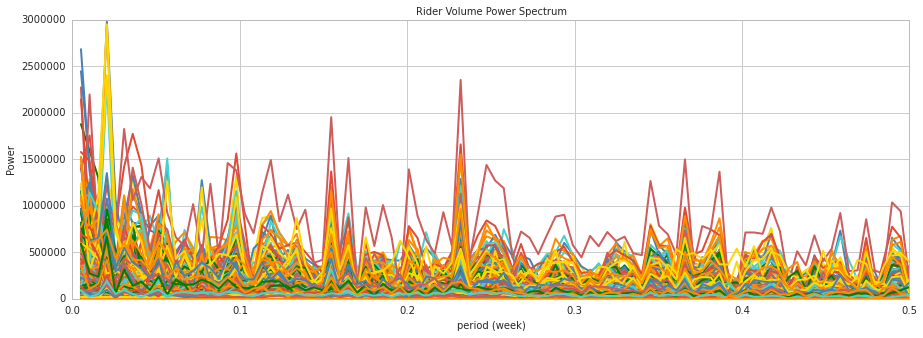

In [383]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

m = np.arange(0, 599, 1)
for i in m:
    f = np.abs(np.fft.rfft(mta_data[i]))
    #print (1.0/np.fft.rfftfreq(N, 1.0)[0:2])
    #print (1.0/np.fft.rfftfreq(N, 1.0)[-3:-1])
    #ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5, alpha = .5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    #ax.set_xticklabels([ "%s"% f for f in ax.get_xticks()], fontsize=10)
    pl.xlabel("period (week)", fontsize=10)
    pl.ylabel("Power", fontsize=10)
    pl.title("Rider Volume Power Spectrum", fontsize=10)
    pl.legend(fontsize = 5)

In [389]:
#Now we want to check the power spectrum by each station.
fig = plt.figure(figsize=(15,400)) 
x = 1

for i in range(0,599):
    f = np.abs(np.fft.rfft(mta_data[i]))
    ax = fig.add_subplot(200,3,x)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=4, color = 'blue',alpha=.5)
    plt.axvline(1.0/52, color='r', linestyle='-')
    pl.xlim (0,0.05)
    #pl.xlabel("period", fontsize=5)
    #pl.ylabel("Power", fontsize=5)
    pl.title(i, fontsize=10)
    #pl.legend([i], fontsize = 8)
    x = x+1 

Based on the graphs above, the top 4 stations are __0, 150, 194, 327__.